In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Sequence
from functools import cached_property

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def to_rgb(img, minval, maxval):
    return (img - minval) / (maxval - minval)

def strip(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [3]:
class Sine(nn.Module):
    def __init__(self, freq=1.0):
        super().__init__()
        self.freq = freq

    def forward(self, inputs):
        return torch.sin(self.freq * inputs)

    def __repr__(self):
        return f"Sine(w0={self.freq})"


class ModulatedLayer(nn.Module):
    def __init__(
        self,
        n_inputs: int,
        n_outputs: int,
        n_dims: int,
        non_linearity = None,
        scale: float = 1.0,
    ):
        super().__init__()
        conv = nn.Conv2d if n_dims == 2 else nn.Conv3d
        self.linear = conv(n_inputs, n_outputs, kernel_size=1, bias=True)
        self.non_linearity = Sine(scale) if non_linearity is None else non_linearity
        self.scale = scale
        self.reset_parameters()

    def reset_parameters(self, start=False):
        n_in = self.linear.in_channels
        if start:
            b = 1 / n_in
        else:
            b = math.sqrt(6 / n_in) / self.scale
        nn.init.uniform_(self.linear.weight, -b, b)
        nn.init.zeros_(self.linear.bias)  # type: ignore

    def forward(self, x, shift_mod=0.0, scale_mod=1.0):
        return self.non_linearity(scale_mod * (self.linear(x) + shift_mod))


# Testing SIREN

In [4]:
class SIREN(nn.Module):
    def __init__(
        self,
        ndim: int,
        num_outs: int,
        grid_size: int,
        features: Sequence[int] = (64, 64, 64, 64),
        w0: float = 30.0,
        w: float = 1.0,
        grid_range: tuple[float, float] = (-1, 1),
    ):
        super().__init__()

        layers, layer_inputs = nn.ModuleList(), ndim
        for i in range(len(features)):
            layers.append(ModulatedLayer(
                n_dims=ndim,
                n_inputs=layer_inputs,
                n_outputs=features[i],
                scale=w0 if i == 0 else w,
            ))
            layer_inputs = features[i]

        output_layer = ModulatedLayer(
            n_inputs=features[-1],
            n_dims=ndim,
            n_outputs=num_outs,
            scale=w,
            non_linearity=nn.Identity(),
        )

        self.ndim = ndim
        self.grid_size = grid_size
        self.grid_range = grid_range
        self.layers = layers
        self.output_layer = output_layer
        self.layers[0].reset_parameters(start=True)  # type: ignore

    def reset_parameters(self):
        for i, mod in enumerate(self.modulated_layers):
            mod.reset_parameters(i == 0)  # type: ignore

    @cached_property
    def grid(self):
        return torch.stack(
            torch.meshgrid(*[
                torch.linspace(
                    start=self.grid_range[0],
                    end=self.grid_range[1],
                    steps=
                    self.grid_size
            )] * self.ndim, indexing='ij'
        ), dim=0)

    @property
    def n_layers(self):
        return len(self.layers)

    def init_grid(self, z):
        return self.grid[None].expand(len(z), *([-1] * (self.ndim + 1)))

    def forward(self, target):
        h = self.init_grid(target)
        for layer in (self.layers):
            h = layer(h)
        return self.output_layer(h)

In [5]:
siren = SIREN(
    ndim=2, 
    num_outs=3,
    grid_size=21,
    features=(64,64), 
    w0=30,
)

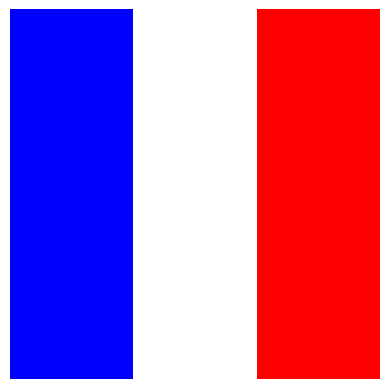

In [6]:
flag  = torch.zeros(64, 3, 21, 21)
flag[:, 2, ..., :7] = 1.0
flag[..., 7:-7] = 1.0
flag[:, 0, ..., -7:] = 1.0


plt.imshow(flag.permute(0, 2, 3, 1)[0])
plt.axis('off');

In [7]:
adam = optim.Adam(lr=1e-3, params=siren.parameters())
criterion = nn.MSELoss()

for _ in (pbar := tqdm(range(2000), ncols=99)):
    adam.zero_grad()
    recons = siren(flag)
    loss = criterion(recons, flag)
    loss.backward()
    adam.step()
    pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

100%|████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.28it/s, Loss: 0.0000]


In [8]:
with torch.no_grad():
    siren.eval()
    recons = siren(0.1 * torch.randn(1, 2, 1, 1))
    # recons = to_rgb(recons, recons.min(), recons.max())
    recons = recons.clip(0, 1)

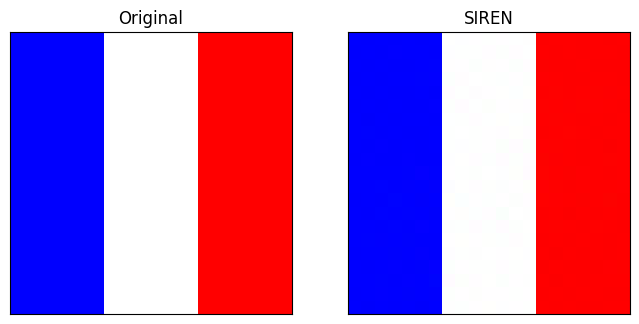

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(flag.permute(0, 2, 3, 1)[0])
ax2.imshow(recons[0].permute(1, 2, 0).numpy())
strip(ax1)
strip(ax2)
ax1.set_title('Original')
ax2.set_title('SIREN');

# Testing ModulatedSIREN

In [10]:
class SpatialModulationBlock(nn.Module):
    def __init__(
        self,
        ndim: int,
        num_outs: int,
        grid_size: int,
        features: Sequence[int] = (64, 64, 64, 64),
        latent_dim: int = 16,
        use_shifts: bool = False,
        use_scales: bool = True,
        w0: float = 30.0,
        w: float = 1.0,
        interpolation: str = 'linear',
        grid_range: tuple[float, float] = (-1, 1),
    ):
        super().__init__()
        assert use_shifts or use_scales
        assert interpolation in ['linear', 'nearest']

        if ndim == 2:
            conv = nn.Conv2d
            if interpolation == "linear":
                interpolation = "bilinear"
        else:
            conv = nn.Conv3d
            if interpolation == "linear":
                interpolation = "trilinear"

        modulated_layers, layer_inputs = nn.ModuleList(), ndim
        for i in range(len(features)):
            modulated_layers.append(ModulatedLayer(
                n_dims=ndim,
                n_inputs=layer_inputs,
                n_outputs=features[i],
                scale = w0 if i == 0 else w,
            ))
            layer_inputs = features[i]

        output_layer = ModulatedLayer(
            n_inputs=features[-1],
            n_dims=ndim,
            n_outputs=num_outs,
            scale=w,
            non_linearity=nn.Identity(),
        )

        split_sizes = list(features)
        if use_shifts:
            shift_modulations = nn.Sequential(
                conv(latent_dim, sum(features), kernel_size=1),
                nn.ReLU()
            )
        else:
            shift_modulations = lambda x: torch.zeros(1, len(features), device=x.device)

        if use_scales:
            scale_modulations = nn.Sequential(
                conv(latent_dim, sum(features), kernel_size=1),
                nn.ReLU()
            )
        else:
            scale_modulations = lambda x: torch.ones(1, len(features), device=x.device)

        # substrate
        self.ndim = ndim
        self.grid_size = grid_size
        self.grid_range = grid_range
        # latent
        self.latent_dim = latent_dim
        self.use_scales = use_scales
        self.use_shifts = use_shifts
        # layers
        self.modulated_layers = modulated_layers
        self.output_layer = output_layer
        self.shift_modulations = shift_modulations
        self.scale_modulations = scale_modulations
        self.split_sizes = split_sizes
        self.interpolation = interpolation
        self.modulated_layers[0].reset_parameters(start=True)  # type: ignore

    def reset_parameters(self):
        for i, mod in enumerate(self.modulated_layers):
            mod.reset_parameters(i == 0)  # type: ignore

    @cached_property
    def grid(self):
        return torch.stack(
            torch.meshgrid(*[
                torch.linspace(
                    start=self.grid_range[0],
                    end=self.grid_range[1],
                    steps=
                    self.grid_size
            )] * self.ndim, indexing='ij'
        ), dim=0)

    @property
    def n_layers(self):
        return len(self.modulated_layers)

    def init_grid(self, z):
        return self.grid[None].expand(len(z), *([-1] * (self.ndim + 1))).to(z.device)

    def forward(self, z):
        assert z.shape[1] == self.latent_dim
        z = z[..., None, None]
        shift_mods = self.shift_modulations(z)
        if self.use_shifts:
            shift_mods = torch.split(shift_mods, self.split_sizes, dim=1)
        else:
            shift_mods = torch.chunk(shift_mods, self.n_layers, dim=1)

        scale_mods = self.scale_modulations(z)
        if self.use_scales:
            scale_mods = torch.split(scale_mods, self.split_sizes, dim=1)
        else:
            scale_mods = torch.chunk(scale_mods, self.n_layers, dim=1)

        h = self.init_grid(z)
        for mod_layer, shift, scale in zip(self.modulated_layers, shift_mods, scale_mods):
            h = mod_layer(h, shift, scale)
        return self.output_layer(h)

In [11]:
modulated_siren = SpatialModulationBlock(
    ndim=2, 
    num_outs=3,
    grid_size=21,
    features=(64, 64), 
    use_scales=True, 
    use_shifts=False,
    w0=30,
    w=30
)
modulated_siren

SpatialModulationBlock(
  (modulated_layers): ModuleList(
    (0): ModulatedLayer(
      (linear): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1))
      (non_linearity): Sine(w0=30)
    )
    (1): ModulatedLayer(
      (linear): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (non_linearity): Sine(w0=30)
    )
  )
  (output_layer): ModulatedLayer(
    (linear): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (non_linearity): Identity()
  )
  (scale_modulations): Sequential(
    (0): Conv2d(16, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
)

In [12]:
adam = optim.Adam(lr=1e-3, params=modulated_siren.parameters())
criterion = nn.MSELoss()

for _ in (pbar := tqdm(range(3000), ncols=99)):
    adam.zero_grad()
    recons = modulated_siren(torch.randn(64, 16))
    loss = criterion(recons, flag)
    loss.backward()
    adam.step()
    pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

100%|████████████████████████████████████████████| 3000/3000 [01:34<00:00, 31.82it/s, Loss: 0.0001]


In [13]:
with torch.no_grad():
    modulated_siren.eval()
    recons = modulated_siren(torch.randn(1, 16))
    recons = to_rgb(recons, recons.min(), recons.max())
    # recons = recons.clip(0, 1)

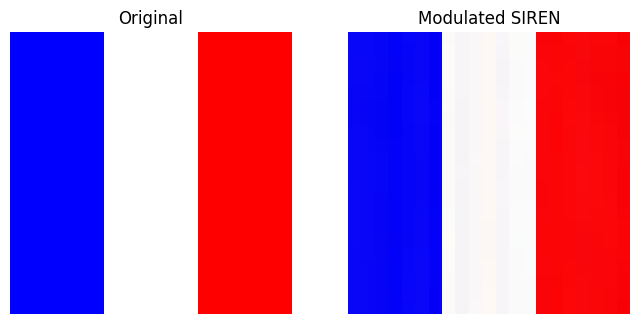

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(flag.permute(0, 2, 3, 1)[0])
ax2.imshow(recons[0].permute(1, 2, 0).numpy())
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Modulated SIREN');

# Train on more than one image

In [15]:
from torch.utils.data import Dataset
from matplotlib.patches import Polygon
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [16]:
import numpy as np
from PIL import Image

def draw_flag_france(size):
    flag = np.ones((size, size, 3))
    w = size // 3
    flag[:, :w] = [0, 0, 1]  # Blue
    flag[:, w:2*w] = [1, 1, 1]  # White
    flag[:, 2*w:] = [1, 0, 0]  # Red
    return flag

def draw_flag_germany(size):
    flag = np.zeros((size, size, 3))
    h = size // 3
    flag[:h] = [0, 0, 0]  # Black
    flag[h:2*h] = [1, 0, 0]  # Red
    flag[2*h:] = [1, 0.843, 0]  # Yellow
    return flag

def draw_flag_japan(size):
    flag = np.ones((size, size, 3))  # White background
    cy, cx = size // 2, size // 2
    r = size // 3
    Y, X = np.ogrid[:size, :size]
    mask = (X - cx)**2 + (Y - cy)**2 <= r**2
    flag[mask] = [1, 0, 0]  # Red circle
    return flag

def draw_flag_italy(size):
    flag = np.ones((size, size, 3))
    w = size // 3
    flag[:, :w] = [0, 1, 0]  # Green
    flag[:, w:2*w] = [1, 1, 1]  # White
    flag[:, 2*w:] = [1, 0, 0]  # Red
    return flag

def draw_flag_netherlands(size):
    flag = np.ones((size, size, 3))
    h = size // 3
    flag[:h] = [1, 0, 0]  # Red
    flag[h:2*h] = [1, 1, 1]  # White
    flag[2*h:] = [0, 0, 1]  # Blue
    return flag

def draw_flag_jamaica(size):
    fig, ax = plt.subplots(figsize=(2, 2), dpi=32)  # 64x64 px
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_aspect('equal')
    ax.axis('off')
    green = '#007847'
    black = '#000000'
    gold = '#FFB915'
    w = size // 4  # ancho de la cruz dorada
    # Triángulo verde arriba
    ax.add_patch(Polygon([[0, size], [size // 2, size // 2 + w], [size, size]], color=green))
    # Triángulo verde abajo
    ax.add_patch(Polygon([[0, 0], [size // 2, size // 2 - w], [size, 0]], color=green))
    # Triángulo negro izquierda
    ax.add_patch(Polygon([[0, size], [size // 2 - w, size // 2], [0, 0]], color=black))
    # Triángulo negro derecha
    ax.add_patch(Polygon([[size, size], [size // 2 + w, size // 2], [size, 0]], color=black))
    # Franja dorada de arriba izquierda a abajo derecha
    ax.add_patch(Polygon([
        [0, 0], [w, 0], [size, size - w], [size, size], [size - w, size], [0, w]
    ], color=gold))
    # Franja dorada de abajo izquierda a arriba derecha
    ax.add_patch(Polygon([
        [0, size], [w, size], [size, w], [size, 0], [size - w, 0], [0, size - w]
    ], color=gold))
    plt.tight_layout()
    canvas = FigureCanvas(fig)
    canvas.draw()

    fig.canvas.print_figure('/tmp/fig.png', bbox_inches='tight', pad_inches=0)
    # Load the image as a numpy array
    image = Image.open("/tmp/fig.png").convert('RGB')  # Load image
    image = image.resize((size, size))
    image = np.array(image)
    
    # image = np.frombuffer(canvas.tostring_argb(), dtype=np.uint8)
    # image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # Reshape to (height, width, 4)
    
    # # Convert ARGB to RGBA (Matplotlib uses ARGB, we need RGBA)
    # image = image[..., [1, 2, 3, 0]]  # Reorder to RGBA
    plt.close()
    return image

def draw_flag_belgium(size):
    flag = np.ones((size, size, 3))
    w = size // 3
    flag[:, :w] = [0, 0, 0]  # Black
    flag[:, w:2*w] = [1, 0.843, 0]  # Yellow
    flag[:, 2*w:] = [1, 0, 0]  # Red
    return flag


def draw_flag_brazil(size):
    flag = np.ones((size, size, 3))  # Green background
    flag[:, :] = [0, 0.5, 0]  # Green
    cy, cx = size // 2, size // 2
    r = size // 4
    Y, X = np.ogrid[:size, :size]
    mask = (X - cx)**2 + (Y - cy)**2 <= r**2
    # Add yellow rhombus
    for i in range(size):
        for j in range(size * 4 // 2):
            if abs(i - cy) + abs(j - cx) < size // 2:
                flag[i, j] = [1, 1, 0]
    flag[mask] = [0, 0, 1]  # Blue circle
    # Covers the lower half of the blue circle
    mask_white_half = (Y - cy) > 0
    flag[mask & mask_white_half] = [1, 1, 1]
    return flag


def draw_flag_denmark(size):
    flag = np.zeros((size, size, 3))
    flag[:, :] = [1, 0, 0]  # Red background
    h = size // 5
    w = size // 5
    flag[:, size // 3 - w//2:size // 3 + w//2] = [1, 1, 1]  # Vertical cross
    flag[size // 2 - h//2:size // 2 + h//2, :] = [1, 1, 1]  # Horizontal cross
    return flag

def draw_flag_sweden(size):
    flag = np.zeros((size, size, 3))
    flag[:, :] = [0, 0, 1]  # Blue background
    h = size // 5
    w = size // 5
    flag[:, size // 3 - w//2:size // 3 + w//2] = [1, 1, 0]  # Vertical cross
    flag[size // 2 - h//2:size // 2 + h//2, :] = [1, 1, 0]  # Horizontal cross
    return flag

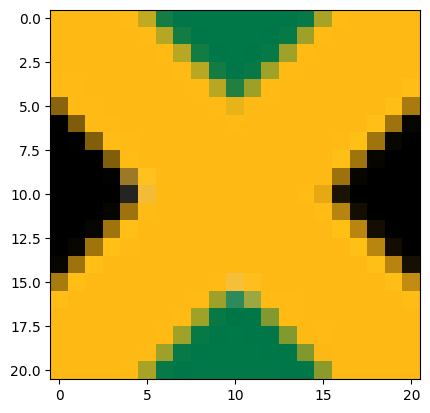

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

flag_functions = [
    draw_flag_france, draw_flag_germany, draw_flag_japan,
    draw_flag_italy, draw_flag_netherlands, draw_flag_jamaica,
    draw_flag_belgium, draw_flag_brazil, draw_flag_denmark, draw_flag_sweden
]

class FlagDataset(Dataset):
    def __init__(self, flag_functions, size, dataset_size=1000):
        """
        Args:
            flag_functions (list): List of functions to generate flags.
            size (int): Size of the flag image.
        """
        self.flags = [flag_fn(size) for flag_fn in flag_functions]
        self.size = size
        self.dataset_size = dataset_size
        self.transform = ToTensor()

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        flag_id = idx % len(self.flags)
        flag = self.transform(self.flags[flag_id])
        return flag_id, flag


dataset = FlagDataset(flag_functions, size=21)

# Sample flag from dataset
sample_flag = dataset[5][1]
plt.imshow(sample_flag.permute(1, 2, 0))

In [18]:
class AutoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.flags), embedding_dim=latent_dim)
        self.modulated_siren = SpatialModulationBlock(
            ndim=2, 
            num_outs=3,
            grid_size=21,
            features=(64, 64, 64), 
            latent_dim=latent_dim,
            use_scales=True, 
            use_shifts=False,
            w0=30,
            w=30
        )

    def forward(self, inputs):
        emb = self.embedding(inputs)
        return self.modulated_siren(emb)

In [19]:
dataset = FlagDataset(flag_functions, size=21, dataset_size=10000)

dataloader = DataLoader(
    dataset,
    batch_size=64,
)

autodecoder = AutoDecoder(64)
adam = optim.Adam(lr=1e-4, params=autodecoder.parameters())
criterion = nn.MSELoss()

i = 0
while i < 5000 :
    for (y, x) in (pbar := tqdm(dataloader, ncols=99)):
        adam.zero_grad()
        recons = autodecoder(y)
        loss = criterion(recons, x.to(dtype=torch.float32))
        loss.backward()
        adam.step()
        pbar.set_postfix_str(f"Loss iter {i}: {loss.item():.4f}")
        i += 1

100%|████████████████████████████████████| 157/157 [00:08<00:00, 18.05it/s, Loss iter 5023: 0.0000]


In [20]:
batch = next(iter(dataloader))

recons = autodecoder(batch[0]).detach()

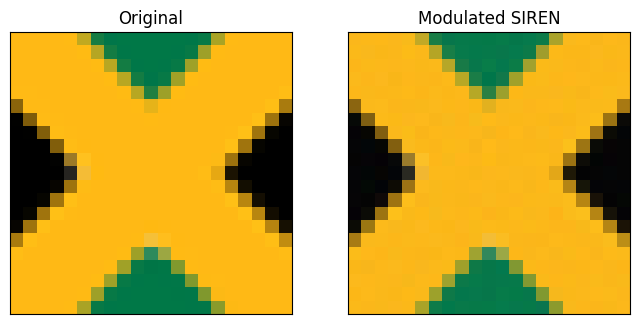

In [21]:
idx = 5

original = batch[1][idx].permute(1, 2, 0).numpy()
example = recons[idx].permute(1, 2, 0).numpy()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(original)
ax2.imshow(to_rgb(example, minval=example.min(), maxval=example.max()))
strip(ax1)
strip(ax2)
ax1.set_title('Original')
ax2.set_title('Modulated SIREN');

# GON

In [38]:
nc = 3
def vae_loss(p, x, mu, logvar, weight=0.0):
    B, C, H, W = x.shape
    BCE = torch.nn.functional.binary_cross_entropy_with_logits(p.view(-1, C * H * W), x.view(-1, C * H * W), reduction='none').sum(1).mean()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    return BCE + (KLD * weight), BCE, KLD


class DiagonalGaussian(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.size = latent_size
        self.linear = nn.Linear(input_size, 2 * latent_size)

    def reparam(self, mu, logvar, random_eval=False):
        if self.training or random_eval:
            # std = exp(log(var))^0.5
            std = logvar.mul(0.5).exp()
            eps = torch.randn_like(std)
            # z = mu + std * eps
            return mu.addcmul(std, eps)
        return mu

    def sample(self, inputs, n_samples=1):
        h = self.linear(inputs)
        mu, logvar = h.unsqueeze_(1).expand(-1, n_samples, -1).chunk(2, dim=-1)
        return self.reparam(mu, logvar, random_eval=True)

    def forward(self, inputs):
        mu, logvar = self.linear(inputs).chunk(2, dim=-1)
        return self.reparam(mu, logvar), (mu, logvar)

    def extra_repr(self):
        return 'size={}'.format(self.size)
        

class GON_SIREN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.stochastic = DiagonalGaussian(latent_dim, latent_dim)
        self.modulated_siren = SpatialModulationBlock(
            ndim=2, 
            num_outs=3,
            grid_size=21,
            features=(64, 64, 64), 
            latent_dim=latent_dim,
            use_scales=True, 
            use_shifts=False,
            w0=30,
            w=30
        )

    def forward(self, inputs):
        # compute the gradients of the inner loss with respect to zeros (gradient origin)
        h = self.infer(inputs)
        z, params = self.stochastic(h)
        return self.modulated_siren(z), params

    def infer(self, inputs):
        h = inputs.new_zeros((len(inputs), self.stochastic.size), requires_grad=True)
        z, (mu, logvar) = self.stochastic(h)
        g = self.modulated_siren(z)
        inner_loss, BCE, KLD = vae_loss(g, inputs, mu, logvar, 1.0)
        grad = torch.autograd.grad(inner_loss, [h], create_graph=True, retain_graph=True)[0]
        return -grad

In [ ]:
gsiren = GON_SIREN(64)
adam = optim.Adam(lr=1e-4, params=gsiren.parameters())
criterion = vae_loss

i = 0
while i < 5000 :
    for (y, x) in (pbar := tqdm(dataloader, ncols=99)):
        x = x.to(dtype=torch.float32)
        adam.zero_grad()
        recons, (mu, logvar) = gsiren(x)
        loss = criterion(recons, x, mu, logvar)[0]
        loss.backward()
        adam.step()
        pbar.set_postfix_str(f"Loss iter {i}: {loss.item():.4f}")
        i += 1

 74%|█████████████████████████         | 116/157 [00:19<00:06,  6.46it/s, Loss iter 1842: 596.7739]